In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess the data
df = pd.read_csv('../data/mulu/mulu-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
df.drop(columns=["Latitude", "Longitude"],inplace=True)

In [2]:
df

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Elevation
DateTime,,,,,,,,,,,,
2010-11-26,16.0,25.06,26.7,-1.64,81.090909,74.909091,82.409091,6.000000,5.909091,29.668182,224.000780,28.7
2010-11-27,16.0,25.06,26.7,-1.64,79.875000,74.416667,84.500000,6.000000,5.750000,29.683750,57.239884,28.7
2010-11-28,8.0,25.06,26.7,-1.64,80.826087,76.130435,86.217391,6.000000,4.173913,29.671739,27.028382,28.7
2010-11-29,11.5,25.06,26.7,-1.64,81.125000,76.666667,86.750000,6.000000,4.708333,29.637500,275.746991,28.7
2010-11-30,17.5,25.06,26.7,-1.64,78.181818,75.545455,91.954545,5.681818,5.590909,29.619091,166.150255,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.4,27.12,26.6,0.52,80.208333,78.416667,94.375000,5.708333,3.500000,29.756250,16.924704,28.7
2019-12-28,3.0,27.12,26.6,0.52,79.541667,77.666667,93.791667,5.458333,4.041667,29.748750,59.331488,28.7
2019-12-29,0.8,27.12,26.6,0.52,83.125000,78.916667,87.041667,6.000000,5.458333,29.740000,46.601550,28.7


In [3]:
# Define the sets of features for interaction
source1 = ['Rainfall']
source2 = ['TOTAL', 'ClimAdjust', 'ANOM']
source3 = ['Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure']
source4 = ['Elevation']

# Create interaction features
for s1 in source1:
    for s2 in source2:
        # Interaction between source1 and source2
        df[f'{s1}_{s2}'] = df[s1] * df[s2]        
    for s3 in source3:
        # Interaction between source1 and source3
        df[f'{s1}_{s3}'] = df[s1] * df[s3]
        
for s2 in source2:
    for s3 in source3:
        # Interaction between source2 and source3
        df[f'{s2}_{s3}'] = df[s2] * df[s3]

for i in range(len(source3)):
    for j in range(i + 1, len(source3)):  # Avoid duplicate pairs and self-interaction
        # s3_1 = source3[i]
        # s3_2 = source3[j]
        # interaction_term = f'{s3_1}_{s3_2}'
        # df[interaction_term] = df[s3_1] * df[s3_2]
        df[f'{source3[i]}_{source3[j]}'] = df[source3[i]] * df[source3[j]]

for s4 in source4:
    for s1 in source1:
        # Interaction between source4 and source1
        df[f'{s4}_{s1}'] = df[s4] * df[s1]
    for s2 in source2:
        # Interaction between source4 and source2
        df[f'{s4}_{s2}'] = df[s4] * df[s2]        
    for s3 in source3:
        # Interaction between source4 and source3
        df[f'{s4}_{s3}'] = df[s4] * df[s3]

df['Rainfall_Temperature_Humidity'] = df['Rainfall'] * df['Temperature'] * df['Humidity']
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'TOTAL', 'ClimAdjust', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Elevation', 'Rainfall_TOTAL', 'Rainfall_ClimAdjust', 'Rainfall_ANOM', 'Rainfall_Temperature', 'Rainfall_DewPoint', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindSpeed', 'Rainfall_Pressure', 'TOTAL_Temperature', 'TOTAL_DewPoint', 'TOTAL_Humidity', 'TOTAL_Visibility', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_Temperature', 'ClimAdjust_DewPoint', 'ClimAdjust_Humidity', 'ClimAdjust_Visibility', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_Visibility', 'ANOM_WindSpeed', 'ANOM_Pressure', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_WindSpeed', 'Temperature_Pressure', 'DewPoint_Humidity', 'DewPoint_Visibility', 'DewPoint_WindSpeed', 'DewPoint_Pressure', 'Humidity_Visibility', 'Humidity_WindSpeed', 'Humidity_Pressure', 'Visibility_WindSpeed'

In [4]:
for window in [7,14,30]:
    df[f"Rainfall_{window}d_mean"] = df["Rainfall"].rolling(window).mean()
    df[f"Rainfall_{window}d_std"] = df["Rainfall"].rolling(window).std()
    df[f"Rainfall_{window}d_sum"] = df["Rainfall"].rolling(window).sum()
    df[f"Rainfall_{window}d_min"] = df["Rainfall"].rolling(window).min()
    df[f"Rainfall_{window}d_max"] = df["Rainfall"].rolling(window).max()
    df[f"Rainfall_{window}d_median"] = df["Rainfall"].rolling(window).median()

df.dropna(inplace=True)
print(f"columns length after rolling statistics: {df.columns.size}")

columns length after rolling statistics: 83


In [5]:
# Get the number of null values for each column and sort them in descending order
null_counts = df.isna().sum().sort_values(ascending=False)

# Filter only columns that have null values (count > 0)
null_counts = null_counts[null_counts > 0]

if len(null_counts) > 0:
    print("Columns with null values:")
    print(null_counts)
else:
    print("No null values found in the dataset")

No null values found in the dataset


In [6]:
# Define features and target
target = 'Rainfall'
features = [col for col in df.columns if col != target]

# Split the data
X = df[features]
y = df[target]

# Split into train and test sets
train_size = int(len(df) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale the data using RobustScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Train model
history = model.fit(
    X_train_reshaped, 
    y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

c:\Users\UlamKetum\rainfall-forecast\lstm\.virt\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)         │        73,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,701 (408.99 KB)

 Trainable params: 104,701 (408.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0107 - val_loss: 0.0018
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 4.2941e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 2.7024e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 2.9726e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 2.9114e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 4.3743e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8857e-04 - val_loss: 1.1453e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2141e-04 - val_loss: 0.0016
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5745e-04 - val_loss: 2.9549e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7538e-04 - val_loss: 2.3054e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4408e-04 - val_loss: 5.5073e-04
Epoch 12/50
66/66 

In [7]:
# Define features and target
target = 'Rainfall'
features = [col for col in df.columns if col != target]

# Split the data
X = df[features]
y = df[target]

# Split into train and test sets
train_size = int(len(df) * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale the data using RobustScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define lookback period
lookback = 7

# Create sequences for LSTM
def create_sequences(data, lookback):
    sequences = []
    for i in range(len(data) - lookback):
        sequences.append(data[i:i + lookback])
    return np.array(sequences)

X_train_sequences = create_sequences(X_train_scaled, lookback)
X_test_sequences = create_sequences(X_test_scaled, lookback)
y_train_sequences = y_train_scaled[lookback:]
y_test_sequences = y_test_scaled[lookback:]

# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_sequences.reshape((X_train_sequences.shape[0], lookback, X_train_sequences.shape[2]))
X_test_reshaped = X_test_sequences.reshape((X_test_sequences.shape[0], lookback, X_test_sequences.shape[2]))

# Build LSTM model
model1 = Sequential([
    LSTM(100, activation='relu', input_shape=(lookback, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model1.summary()

# Train model
history1 = model1.fit(
    X_train_reshaped, 
    y_train_sequences,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

c:\Users\UlamKetum\rainfall-forecast\lstm\.virt\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 100)         │        73,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,701 (408.99 KB)

 Trainable params: 104,701 (408.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0168 - val_loss: 0.0180
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0179
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0179
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0174
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0176
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0170
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0171
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0177
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - val_loss: 0.0172
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0172
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0171
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_lo

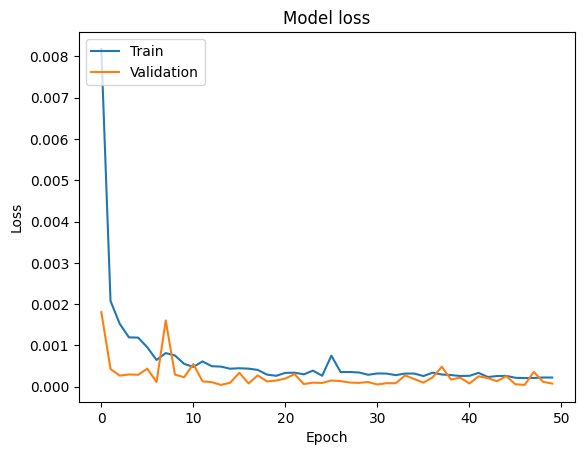

In [8]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

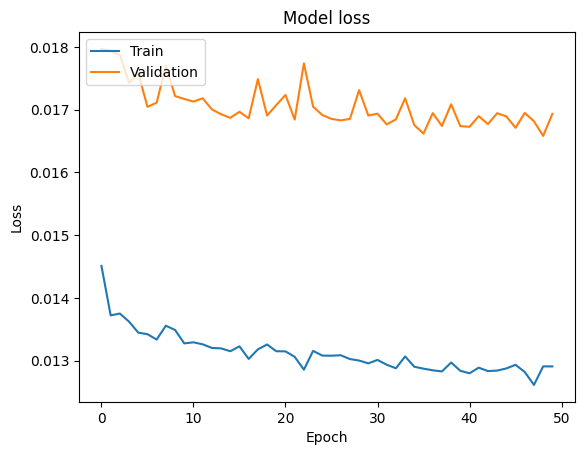

In [9]:
# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


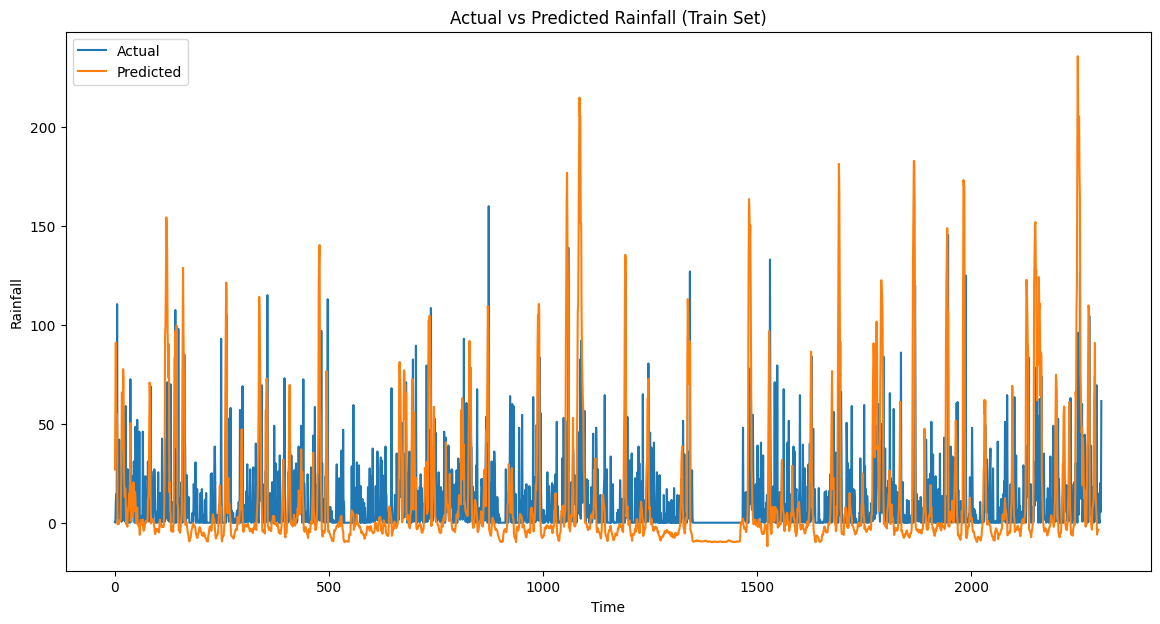

In [10]:
# Predict on the training set
y_train_pred_scaled = model.predict(X_train_reshaped)

# Inverse transform the scaled predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_train_actual, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Train Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


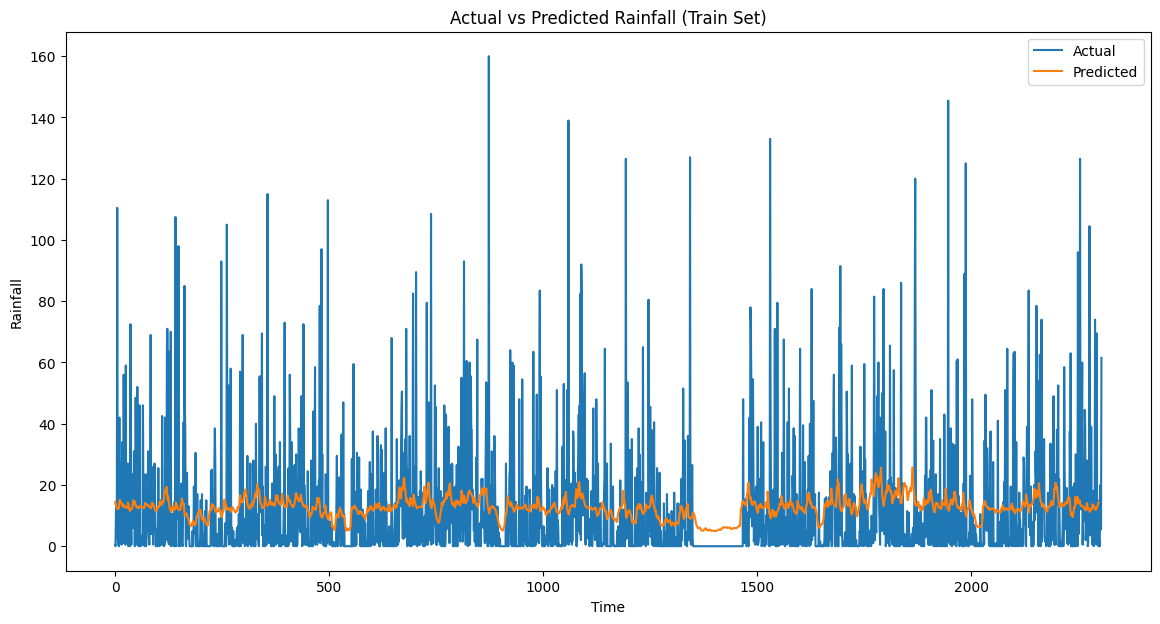

In [11]:
# Predict on the training set
y_train_pred_scaled = model1.predict(X_train_reshaped)

# Inverse transform the scaled predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_train_actual, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Train Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()